## How can a Data Analyst Maximize Salary When Searching for a Job?

In this chapter, we'll uncover factors that influence the salary range for Data Analysts and will specify:
- Must-have skills for Data Analysts and how they affect salary
- Top-paying analytical skills and their impact on salary
- Impact of job type (remote vs on-site) and degree requirements on salary
- SHAP analysis – will uncover key drivers of Data Analyst salaries

### Import Libraries

In [1]:
import ast
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBRegressor
import shap

### Load Cleaned Dataset

In [2]:
df = pd.read_csv(Path.cwd().parents[1] / "Raw_Data" / 'df_Final.csv')

### Remove Salary Outliers
During the exploratory analysis, we identified unusually high salaries in countries with very few job postings. These outliers may result from salaries listed in local currencies, company registration addresses being used instead of actual job locations, or other inconsistencies.

Action Taken:
- Outliers were removed per job title and country to preserve meaningful comparisons.
- For countries with fewer than 5 postings, outliers were removed based on job title only to avoid skewed insights from limited data.

In [3]:
#Calculate global IQR
Q1_global = df['salary_month_avg_eur'].quantile(0.25)
Q3_global = df['salary_month_avg_eur'].quantile(0.75)
IQR_global = Q3_global - Q1_global
lower_bound_global = Q1_global - 1.5 * IQR_global
upper_bound_global = Q3_global + 1.5 * IQR_global

#Build list to collect filtered results
filtered_groups = []

#Iterate over groups manually
for (country, title), group in df.groupby(['job_country', 'job_title_short']):
    if len(group) >= 5:
        Q1 = group['salary_month_avg_eur'].quantile(0.25)
        Q3 = group['salary_month_avg_eur'].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
    else:
        lower = lower_bound_global
        upper = upper_bound_global

    filtered = group[
        (group['salary_month_avg_eur'] >= lower) &
        (group['salary_month_avg_eur'] <= upper)
    ]
    filtered_groups.append(filtered)

# Combine all groups back
df_filtered = pd.concat(filtered_groups, ignore_index=True)

print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_filtered)}")

Original dataset size: 22002
Filtered dataset size: 21309


### Filter Data
Although our main focus is the **European job market**, analyzing US salary trends provides valuable foresight since the United States often leads in technology adoption and skill demand. This helps us benchmark Europe’s position, anticipate emerging trends, and make more informed decisions regarding talent strategy and compensation.

In [4]:
eu_us = ['EU', 'US']

df_da_eu_us = df_filtered[
    (df_filtered['region_group'].isin(eu_us)) &
    (df_filtered['job_title_short'] == 'Data Analyst')
].copy()

To better understand how individual data analyst skills influence salaries, we first extract 'analyst_tools' data, convert the job_skills strings into actual Python lists and explode the lists so each skill appears in a separate row — making it easier to analyze skill-specific trends.

In [5]:
analyst_skills = set()
for row in df_da_eu_us['job_type_skills'].dropna().unique():
    row_dict = ast.literal_eval(row)
    analyst_skills.update(row_dict.get('analyst_tools', []))

df_da = df_da_eu_us.dropna(subset=['job_skills', 'salary_month_avg_eur']).copy()
df_da['job_skills'] = df_da['job_skills'].apply(ast.literal_eval)
df_da = df_da.explode('job_skills')
df_plot = df_da[df_da['job_skills'].isin(analyst_skills)].copy()

### Must-have skills for Data Analysts and how they affect salary

To identify essential analytical tools for data analysts, we first extract the most frequently mentioned skills from job postings. Then, we evaluate which of these skills correlate with higher salaries. This analysis helps job seekers prioritize skill acquisition based on both demand and earning potential.

In [6]:
# Find top 10 skills by number of postings (frequency)
top10_by_count = (
    df_plot['job_skills']
    .value_counts()
    .head(10)
    .index.tolist()
)

df_top10_count = df_plot[df_plot['job_skills'].isin(top10_by_count)]

top10_salary_skills = (
    df_top10_count.groupby('job_skills')['salary_month_avg_eur']
    .median()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top10_salary_skills['job_postings'] = top10_salary_skills['job_skills'].apply(
    lambda s: (df_plot['job_skills'] == s).sum()
)

top10_salary_skills.columns = ['skill', 'median_salary_eur', 'job_postings']
top10_salary_skills = top10_salary_skills.sort_values('median_salary_eur')

top_skills_set = set(top10_salary_skills['skill'])

# Define top 3 highest-paid skills from these top 10
top3_skills_set = set(top10_salary_skills.sort_values('median_salary_eur', ascending=False)['skill'].head(3))

df_plot['has_top_skill'] = df_plot['job_skills'].apply(lambda s: s in top3_skills_set)
df_valid = df_plot.dropna(subset=['salary_month_avg_eur'])

avg_salary = (
    df_valid.groupby('has_top_skill')['salary_month_avg_eur']
    .mean()
    .reset_index()
)

avg_salary['group'] = avg_salary['has_top_skill'].map({
    True: 'With Top 3 Skills',
    False: 'Without Top 3 Skills'
})

# Sort avg_salary to control bar order on plot
avg_salary['group'] = pd.Categorical(
    avg_salary['group'],
    categories=['Without Top 3 Skills', 'With Top 3 Skills'],
    ordered=True
)
avg_salary = avg_salary.sort_values('group')

with_salary = avg_salary.loc[avg_salary['group'] == 'With Top 3 Skills', 'salary_month_avg_eur'].values[0]
without_salary = avg_salary.loc[avg_salary['group'] == 'Without Top 3 Skills', 'salary_month_avg_eur'].values[0]
pct_diff = (with_salary - without_salary) / without_salary * 100

# Plotting
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    subplot_titles=("Top 10 In-Demand Analytical Skills Sorted by Salary", "Avg Salary: With vs Without Top 3 Skills"),
    horizontal_spacing=0.1
)

# Left: horizontal bar for median salary of top 10 skills
fig.add_trace(go.Bar(
    x=top10_salary_skills['median_salary_eur'],
    y=top10_salary_skills['skill'],
    orientation='h',
    marker=dict(color=top10_salary_skills['median_salary_eur'], colorscale='Blues'),
    text=top10_salary_skills['median_salary_eur'].round(0).astype(int),
    textposition='auto',
    name='Top Skills'
), row=1, col=1)

# Bold the top 3 skills on left y-axis
top_3_skills = set(top10_salary_skills.tail(3)['skill'])
ticktext = [f"<b>{s}</b>" if s in top_3_skills else s for s in top10_salary_skills['skill']]

fig.update_yaxes(
    tickmode='array',
    tickvals=top10_salary_skills['skill'],
    ticktext=ticktext,
    row=1, col=1
)

# Right: bar for avg salary with/without top 3 skills
fig.add_trace(go.Bar(
    x=avg_salary['group'],
    y=avg_salary['salary_month_avg_eur'],
    marker_color=['#9ecae1' if g == 'Without Top 3 Skills' else '#084594' for g in avg_salary['group']],
    text=avg_salary['salary_month_avg_eur'].round(0).astype(int),
    textposition='auto',
    name='Group Comparison'
), row=1, col=2)

fig.update_yaxes(
    range=[0, avg_salary['salary_month_avg_eur'].max() * 1.2],
    row=1, col=2
)

fig.add_annotation(
    x=0.5,
    y=max(avg_salary['salary_month_avg_eur']) * 1.1,
    text=f'+{pct_diff:.1f}%',
    showarrow=False,
    font=dict(size=14, color='gray'),
    xref='x2',
    yref='y2'
)

fig.update_layout(
    height=500,
    width=1000,
    template='plotly_white',
    showlegend=False,
    margin=dict(t=60, b=40, l=60, r=40),
)

fig.update_xaxes(title_text='Median Salary, EUR', row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_yaxes(title_text='', row=1, col=1)
fig.update_xaxes(title_text='', row=1, col=2)
fig.update_yaxes(title_text='', showticklabels=False, row=1, col=2)

fig.show()

Tools like **Looker**, **Tableau**, and **Power BI** top the list, offering the highest salary within the top-10 in-demand skills. Notably, candidates with at least one of the top 3 tools command an 8.2% higher average salary compared to those without. This emphasizes the strategic value of learning high-demand BI tools — both for entering the job market and for accelerating salary growth.

### Top-paying analytical skills and their impact on salary

While some tools are commonly requested, others—though less frequent—offer significantly higher salaries. This section uncovers the most lucrative analytical skills and compares salary outcomes for analysts who possess them versus those who don’t.

In [7]:
# Top 10 highest paid skills in analyst_tools
top10_salary_skills = (
    df_plot.groupby('job_skills')['salary_month_avg_eur']
    .median()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Add job postings count for these skills
top10_salary_skills['job_postings'] = top10_salary_skills['job_skills'].apply(
    lambda s: (df_plot['job_skills'] == s).sum()
)

top10_salary_skills.columns = ['skill', 'median_salary_eur', 'job_postings']
top10_salary_skills = top10_salary_skills.sort_values('median_salary_eur')
top_skills_set = set(top10_salary_skills['skill'])

# With vs Without top 3 highest-paid skills
top3_skills_set = set(top10_salary_skills.sort_values('median_salary_eur', ascending=False)['skill'].head(3))

df_plot['has_top_skill'] = df_plot['job_skills'].apply(lambda s: s in top3_skills_set)
df_valid = df_plot.dropna(subset=['salary_month_avg_eur'])

avg_salary = (
    df_valid.groupby('has_top_skill')['salary_month_avg_eur']
    .mean()
    .reset_index()
)

avg_salary['group'] = avg_salary['has_top_skill'].map({
    True: 'With Top 3 Skills',
    False: 'Without Top 3 Skills'
})

with_salary = avg_salary.loc[avg_salary['group'] == 'With Top 3 Skills', 'salary_month_avg_eur'].values[0]
without_salary = avg_salary.loc[avg_salary['group'] == 'Without Top 3 Skills', 'salary_month_avg_eur'].values[0]
pct_diff = (with_salary - without_salary) / without_salary * 100

# Plotting
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    subplot_titles=("Top 10 Highest Paid Analytical Skills", "Avg Salary: With vs Without Top 3 Skills"),
    horizontal_spacing=0.1
)

fig.add_trace(go.Bar(
    x=top10_salary_skills['median_salary_eur'],
    y=top10_salary_skills['skill'],
    orientation='h',
    marker=dict(color=top10_salary_skills['median_salary_eur'], colorscale='Blues'),
    text=top10_salary_skills['median_salary_eur'].round(0).astype(int),
    textposition='auto',
    name='Top Skills'
), row=1, col=1)

# Bold the top 3 skills on left y-axis
top_3_skills = set(top10_salary_skills.tail(3)['skill'])
ticktext = [f"<b>{s}</b>" if s in top_3_skills else s for s in top10_salary_skills['skill']]

fig.update_yaxes(
    tickmode='array',
    tickvals=top10_salary_skills['skill'],
    ticktext=ticktext,
    row=1, col=1
)

fig.add_trace(go.Bar(
    x=avg_salary['group'],
    y=avg_salary['salary_month_avg_eur'],
    marker_color=['#9ecae1' if g == 'Without Top 3 Skills' else '#084594' for g in avg_salary['group']],
    text=avg_salary['salary_month_avg_eur'].round(0).astype(int),
    textposition='auto',
    name='Group Comparison'
), row=1, col=2)

fig.update_yaxes(
    range=[0, avg_salary['salary_month_avg_eur'].max() * 1.2],
    row=1, col=2
)

fig.add_annotation(
    x=0.5,
    y=max(avg_salary['salary_month_avg_eur']) * 1.1,
    text=f'+{pct_diff:.1f}%',
    showarrow=False,
    font=dict(size=14, color='gray'),
    xref='x2',
    yref='y2'
)

fig.update_layout(
    height=500,
    width=1000,
    template='plotly_white',
    showlegend=False,
    margin=dict(t=60, b=40, l=60, r=40),
)

fig.update_xaxes(title_text='Median Salary, EUR', row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_yaxes(title_text='', row=1, col=1)
fig.update_xaxes(title_text='', row=1, col=2)
fig.update_yaxes(title_text='', showticklabels=False, row=1, col=2)

fig.show()

- With Top 3 Skills: Job posting has at least one of the top 3 skills.
- Without Top 3 Skills: Job posting has none of the top 3 skills.

Job seekers can boost their salary by over 15% with top-3 highest-paid analyst skills that are **Splunk**, **Alteryx**, and **Looker**. Splunk leads the list but is a niche tool focused on IT and security, making it less common in typical analyst roles. Alteryx specializes in data preparation and automation, offering both high pay and broader relevance. Looker stands out as the most strategic choice—it's both well-paid and widely used in modern analytics teams.

### Impact of job type (remote vs on-site) and degree requirements on salary

Job flexibility and educational requirements can influence compensation. Here, we examine how remote work and the presence of a degree requirement affect average analyst salaries across the EU and US.

In [8]:
# Prepare data (same as before)
remote_salary_avg = df_da_eu_us.groupby('job_work_from_home')['salary_month_avg_eur'].mean().reset_index()
remote_salary_avg['Remote Work'] = remote_salary_avg['job_work_from_home'].map({True: 'Remote', False: 'On-site'})

degree_salary_avg = df_da_eu_us.groupby('job_no_degree_mention')['salary_month_avg_eur'].mean().reset_index()
degree_salary_avg['Degree Mention'] = degree_salary_avg['job_no_degree_mention'].map({True: 'No Degree Mentioned', False: 'Degree Mentioned'})

# Define order and colors
remote_order = ['On-site', 'Remote']
degree_order = ['No Degree Mentioned', 'Degree Mentioned']

colors = ['#9ecae1', '#084594']  # light blue, dark blue

# Reorder data to match order
remote_salary_avg = remote_salary_avg.set_index('Remote Work').loc[remote_order].reset_index()
degree_salary_avg = degree_salary_avg.set_index('Degree Mention').loc[degree_order].reset_index()

# Calculate % differences for annotations
def calc_pct_diff(group_df):
    low = group_df['salary_month_avg_eur'].iloc[0]
    high = group_df['salary_month_avg_eur'].iloc[1]
    return (high - low) / low * 100

remote_pct_diff = calc_pct_diff(remote_salary_avg)
degree_pct_diff = calc_pct_diff(degree_salary_avg)

# Create subplot figure with 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Avg Salary by Remote Work', 'Avg Salary by Degree Mention'))

# Remote Work Bar
fig.add_trace(
    go.Bar(
        x=remote_salary_avg['Remote Work'],
        y=remote_salary_avg['salary_month_avg_eur'],
        marker_color=colors,
        showlegend=False,
        text=remote_salary_avg['salary_month_avg_eur'].round(0).astype(int),
        textposition='auto'
    ),
    row=1,
    col=1
)

# Degree Mention Bar
fig.add_trace(
    go.Bar(
        x=degree_salary_avg['Degree Mention'],
        y=degree_salary_avg['salary_month_avg_eur'],
        marker_color=colors,
        showlegend=False,
        text=degree_salary_avg['salary_month_avg_eur'].round(0).astype(int),
        textposition='auto'
    ),
    row=1,
    col=2
)

fig.add_annotation(
    x=0.5, 
    y=max(remote_salary_avg['salary_month_avg_eur']) * 1.2,
    xref='x domain',  # first subplot x axis
    yref='y',         # first subplot y axis
    text=f'+{remote_pct_diff:.1f}%',
    showarrow=False,
    font=dict(color='grey', size=14)
)

fig.add_annotation(
    x=0.5, 
    y=max(degree_salary_avg['salary_month_avg_eur']) * 1.2,
    xref='x2 domain', # second subplot x axis
    yref='y2',        # second subplot y axis
    text=f'+{degree_pct_diff:.1f}%',
    showarrow=False,
    font=dict(color='grey', size=14)
)

# Update layout: remove y-axis ticks and labels
fig.update_yaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False
)

# Update layout: remove y-axis ticks and labels
fig.update_yaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False
)

for ann in fig['layout']['annotations']: ann['y'] += 0.05

fig.update_layout(
    height=400,
    width=800,
    yaxis_title='',
    template='plotly_white',
)

fig.show()

### SHAP Analysis – Key Drivers of Data Analyst Salaries
To identify which job attributes most strongly influence salaries, we apply SHAP analysis on an XGBoost model. This helps pinpoint actionable features that drive pay levels for analysts.

Test R^2 Score: 0.133
SHAP Feature Importance (as % impact) for Top 5 Features:
skill_excel: 15.7%
skill_python: 10.6%
skill_sql: 5.4%
degree_mentioned: 4.5%
skill_tableau: 4.4%


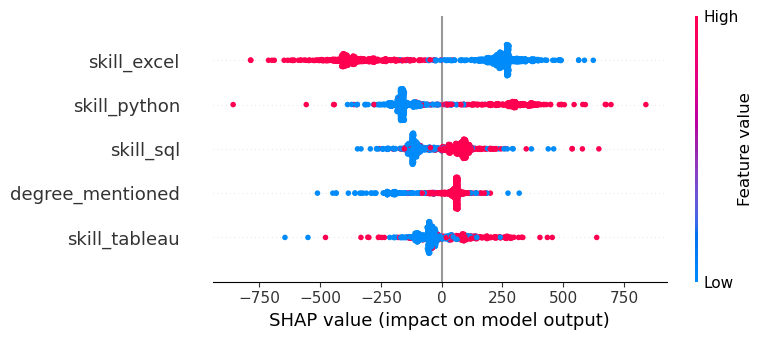

In [9]:
df_da_eu_us['job_posted_date'] = pd.to_datetime(df_da_eu_us['job_posted_date'])

# Create a working copy
df_model = df_da_eu_us.copy()

# Rename and invert logic: degree_mentioned = not job_no_degree_mention
df_model['degree_mentioned'] = ~df_model['job_no_degree_mention']

# Ensure that job_skills is a list
def ensure_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    elif isinstance(x, list):
        return x
    else:
        return []

df_model['job_skills'] = df_model['job_skills'].apply(ensure_list)

# Binarize job_skills
mlb = MultiLabelBinarizer()
skills_encoded = pd.DataFrame(
    mlb.fit_transform(df_model['job_skills']),
    columns=[f"skill_{s}" for s in mlb.classes_],
    index=df_model.index
)

# Ensure boolean features are numeric
df_model['job_work_from_home'] = df_model['job_work_from_home'].astype(int)
df_model['degree_mentioned'] = df_model['degree_mentioned'].astype(int)

# Combine features (excluding month and job_postings_count)
features = pd.concat([
    df_model[['job_work_from_home', 'degree_mentioned']],
    skills_encoded
], axis=1)

# Target variable
target = df_model['salary_month_avg_eur']

# ----- Train/Test Split and Model Training -----
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Test R^2 Score: {score:.3f}")

# ----- SHAP Analysis -----
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

# Top 5 features by impact
top5_features = shap_importance.head(5)['feature'].tolist()
top5_indices = [X_test.columns.get_loc(f) for f in top5_features]

shap_values_top5 = shap_values[:, top5_indices]
X_test_top5 = X_test[top5_features]

# % impact
total_shap = shap_importance['mean_abs_shap'].sum()
shap_importance['percentage_impact'] = 100 * shap_importance['mean_abs_shap'] / total_shap
top5_impacts = shap_importance.set_index('feature').loc[top5_features]['percentage_impact']

print("SHAP Feature Importance (as % impact) for Top 5 Features:")
for feat, impact in top5_impacts.items():
    print(f"{feat}: {impact:.1f}%")

# SHAP plot
shap.summary_plot(shap_values_top5, X_test_top5, feature_names=top5_features)

### Key Insights from SHAP Feature Importance

These features had the highest impact on predicted salaries:

- **Excel** (13.1% impact): Surprisingly the most influential skill. Likely reflects its use in senior finance, strategy, or operations roles.
- **Python** (8.3%): Strongly associated with higher salaries, especially in roles involving automation, scripting, or machine learning.
- **Tableau** (4.6%): Valued for data visualization, though less impactful than core programming skills.
- **SQL** (4.4%): Essential across most roles; its moderate impact suggests it's a baseline skill rather than a differentiator.
- **No Degree Mention** (3.5%): Slightly associated with lower salaries, possibly reflecting more inclusive or junior positions.

**Summary**: While modern tools like Python increase salary, traditional tools like Excel still carry major weight — possibly due to their presence in senior business roles.